# Example Usage

Results are still preliminary. This gives a toy example for how to use the code in this repository for model training, inference, and result visualization. Performance is not yet optimized and there are still more validation tests to finish.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from max_deeplab.model import MaXDeepLabS
from max_deeplab.losses import MaXDeepLabLoss
from datasets.coco_panoptic import build
from torch.optim import Adam
from util.misc import collate_fn
from torch.utils.data import DataLoader
from util.visualize import display_instances, roll_image

from einops import rearrange
from matplotlib import pyplot as plt

In [3]:
config = {}
HW = 224
N = 30 #if the loaded image has more than 30 masks, this number must be increased
bsz = 2 #small batch for a toy example; too small for actual model training

config['image_size'] = (HW, HW)
config['coco_path'] = 'coco_panoptic/' #directory with image and annotation data
data = build('train', config)  ##data是训练数据

#dictionary of class names from Coco Panoptic
category_dict = {dct['id']: dct['name'] for dct in data.coco['categories']}  ##categories类别 应该是一共有200类
category_dict[201] = 'no_class'

#create a dataloader that collates batch with padding
#see utils.misc.collate_fn
padding_dict = {'image': 0, 'masks': 0, 'semantic_mask': 0, 'labels': 0, 'image_id': 0} ##padding values 填充值
sizes_dict = {'image': None, 'masks': N, 'semantic_mask': None, 'labels': N, 'image_id': None} #padded sizes
collate_lambda = lambda b: collate_fn(b, padding_dict, sizes_dict)

loader = DataLoader(data, batch_size=bsz, shuffle=True, collate_fn=collate_lambda, drop_last=True)

#we will just try to overfit a single batch of images  ##过拟合
batch = iter(loader).next() # 加载batch，设置循环规则     ##batch有点像多维数组的首地址

In [ ]:
# ljh_视频处理
import cv2
pred_path = ''
pred_P = {}
pred_img = cv2.imread(pred_path)
pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
pred_P['image'] = pred_img
loader =

In [4]:
device = torch.device('cuda:0')

# 分别放置当前批里的东西
P = batch['image'].to(device)
masks = batch['masks'].to(device)
labels = batch['labels'].to(device)
semantic = batch['semantic_mask'].to(device)   ##semantic 语义的adj

# 造gt元组
target_tuple = (masks, labels, semantic)

In [6]:
## why 202?
model = MaXDeepLabS(im_size=HW, n_classes=202, n_masks=N).cuda() # 每做完一步输出遮罩、类别、语义遮罩？
criterion = MaXDeepLabLoss().cuda() # loss
optimizer = Adam(model.parameters(), lr=5e-4) #RAdam later, just Adam for testing

In [7]:
for i in range(20):
    optimizer.zero_grad()

    out = model(P)
    loss, loss_items = criterion(out, target_tuple)
    loss.backward()
    optimizer.step()

    if (i + 1) % 50 == 0:
        loss_string = ', '.join([f'{k}: {v}' for k,v in loss_items.items()])
        print(f'epoch {i + 1}: ', loss.item())
        print(loss_string)

In [18]:
# ljh-图像显示初始化
gt_instances = []
gt_classes = []
gt_class_names = []

pred_instances = []
pred_classes = []
pred_class_names = []

display_image = []

In [19]:
# ljh-图像显示处理
for i in range(3):
    config = {}
    HW = 224
    N = 30 #if the loaded image has more than 30 masks, this number must be increased
    bsz = 2 #small batch for a toy example; too small for actual model training

    config['image_size'] = (HW, HW)
    config['coco_path'] = 'coco_panoptic/' #directory with image and annotation data
    data = build('train', config)

    #dictionary of class names from Coco Panoptic
    category_dict = {dct['id']: dct['name'] for dct in data.coco['categories']}
    category_dict[201] = 'no_class'

    #create a dataloader that collates batch with padding
    #see utils.misc.collate_fn
    padding_dict = {'image': 0, 'masks': 0, 'semantic_mask': 0, 'labels': 0, 'image_id': 0} #padding values
    sizes_dict = {'image': None, 'masks': N, 'semantic_mask': None, 'labels': N, 'image_id': None} #padded sizes
    collate_lambda = lambda b: collate_fn(b, padding_dict, sizes_dict)

    loader = DataLoader(data, batch_size=bsz, shuffle=True, collate_fn=collate_lambda)

    #we will just try to overfit a single batch of images
    batch = iter(loader).next() # 加载batch，设置循环规则
    device = torch.device('cuda:0')

    # 分别放置当前批里的东西
    P = batch['image'].to(device)
    masks = batch['masks'].to(device)
    labels = batch['labels'].to(device)
    semantic = batch['semantic_mask'].to(device)

    # 造gt元组
    target_tuple = (masks, labels, semantic)
    with torch.no_grad():

        out = model(P)

        instance_probs = F.softmax(out[0], dim=1)
        instances = instance_probs.argmax(dim=1)
        instances = F.one_hot(instances, num_classes=N).permute(0, 3, 1, 2)

        #filter out pixels by mask id confidence
        #instances[instance_probs < 0.4] = 0

        class_confidence, classes = F.softmax(out[1], dim=-1).max(-1)

        semantic = F.softmax(out[2], dim=1).argmax(dim=1)

        #throughout padding instances in gt
        keep_gt_instances = torch.where(batch['labels'].tensors > 0)

        #filter out low confidence instances from predictions
        keep_pred_instances = torch.where(torch.logical_and(classes > 0, class_confidence > 0.7))
    for index in range(bsz):
        keep_gt = keep_gt_instances[1][keep_gt_instances[0] == index]
        keep_pred = keep_pred_instances[1][keep_pred_instances[0] == index]

        gt_instances.append(batch['masks'].tensors.detach()[index, keep_gt].cpu().numpy())
        gt_classes.append(batch['labels'].tensors.detach()[index, keep_gt].cpu().numpy())
        gt_class_names.append([category_dict[l] for l in gt_classes[-1]])

        pred_instances.append(instances.detach()[index, keep_pred].cpu().numpy())
        pred_classes.append(classes.detach()[index, keep_pred].cpu().numpy())
        pred_class_names.append([category_dict[l] for l in pred_classes[-1]])

        # display append
        display_image.append(roll_image(batch['image'].tensors.detach().cpu().numpy()[index]))
    print(i)

0
1
2


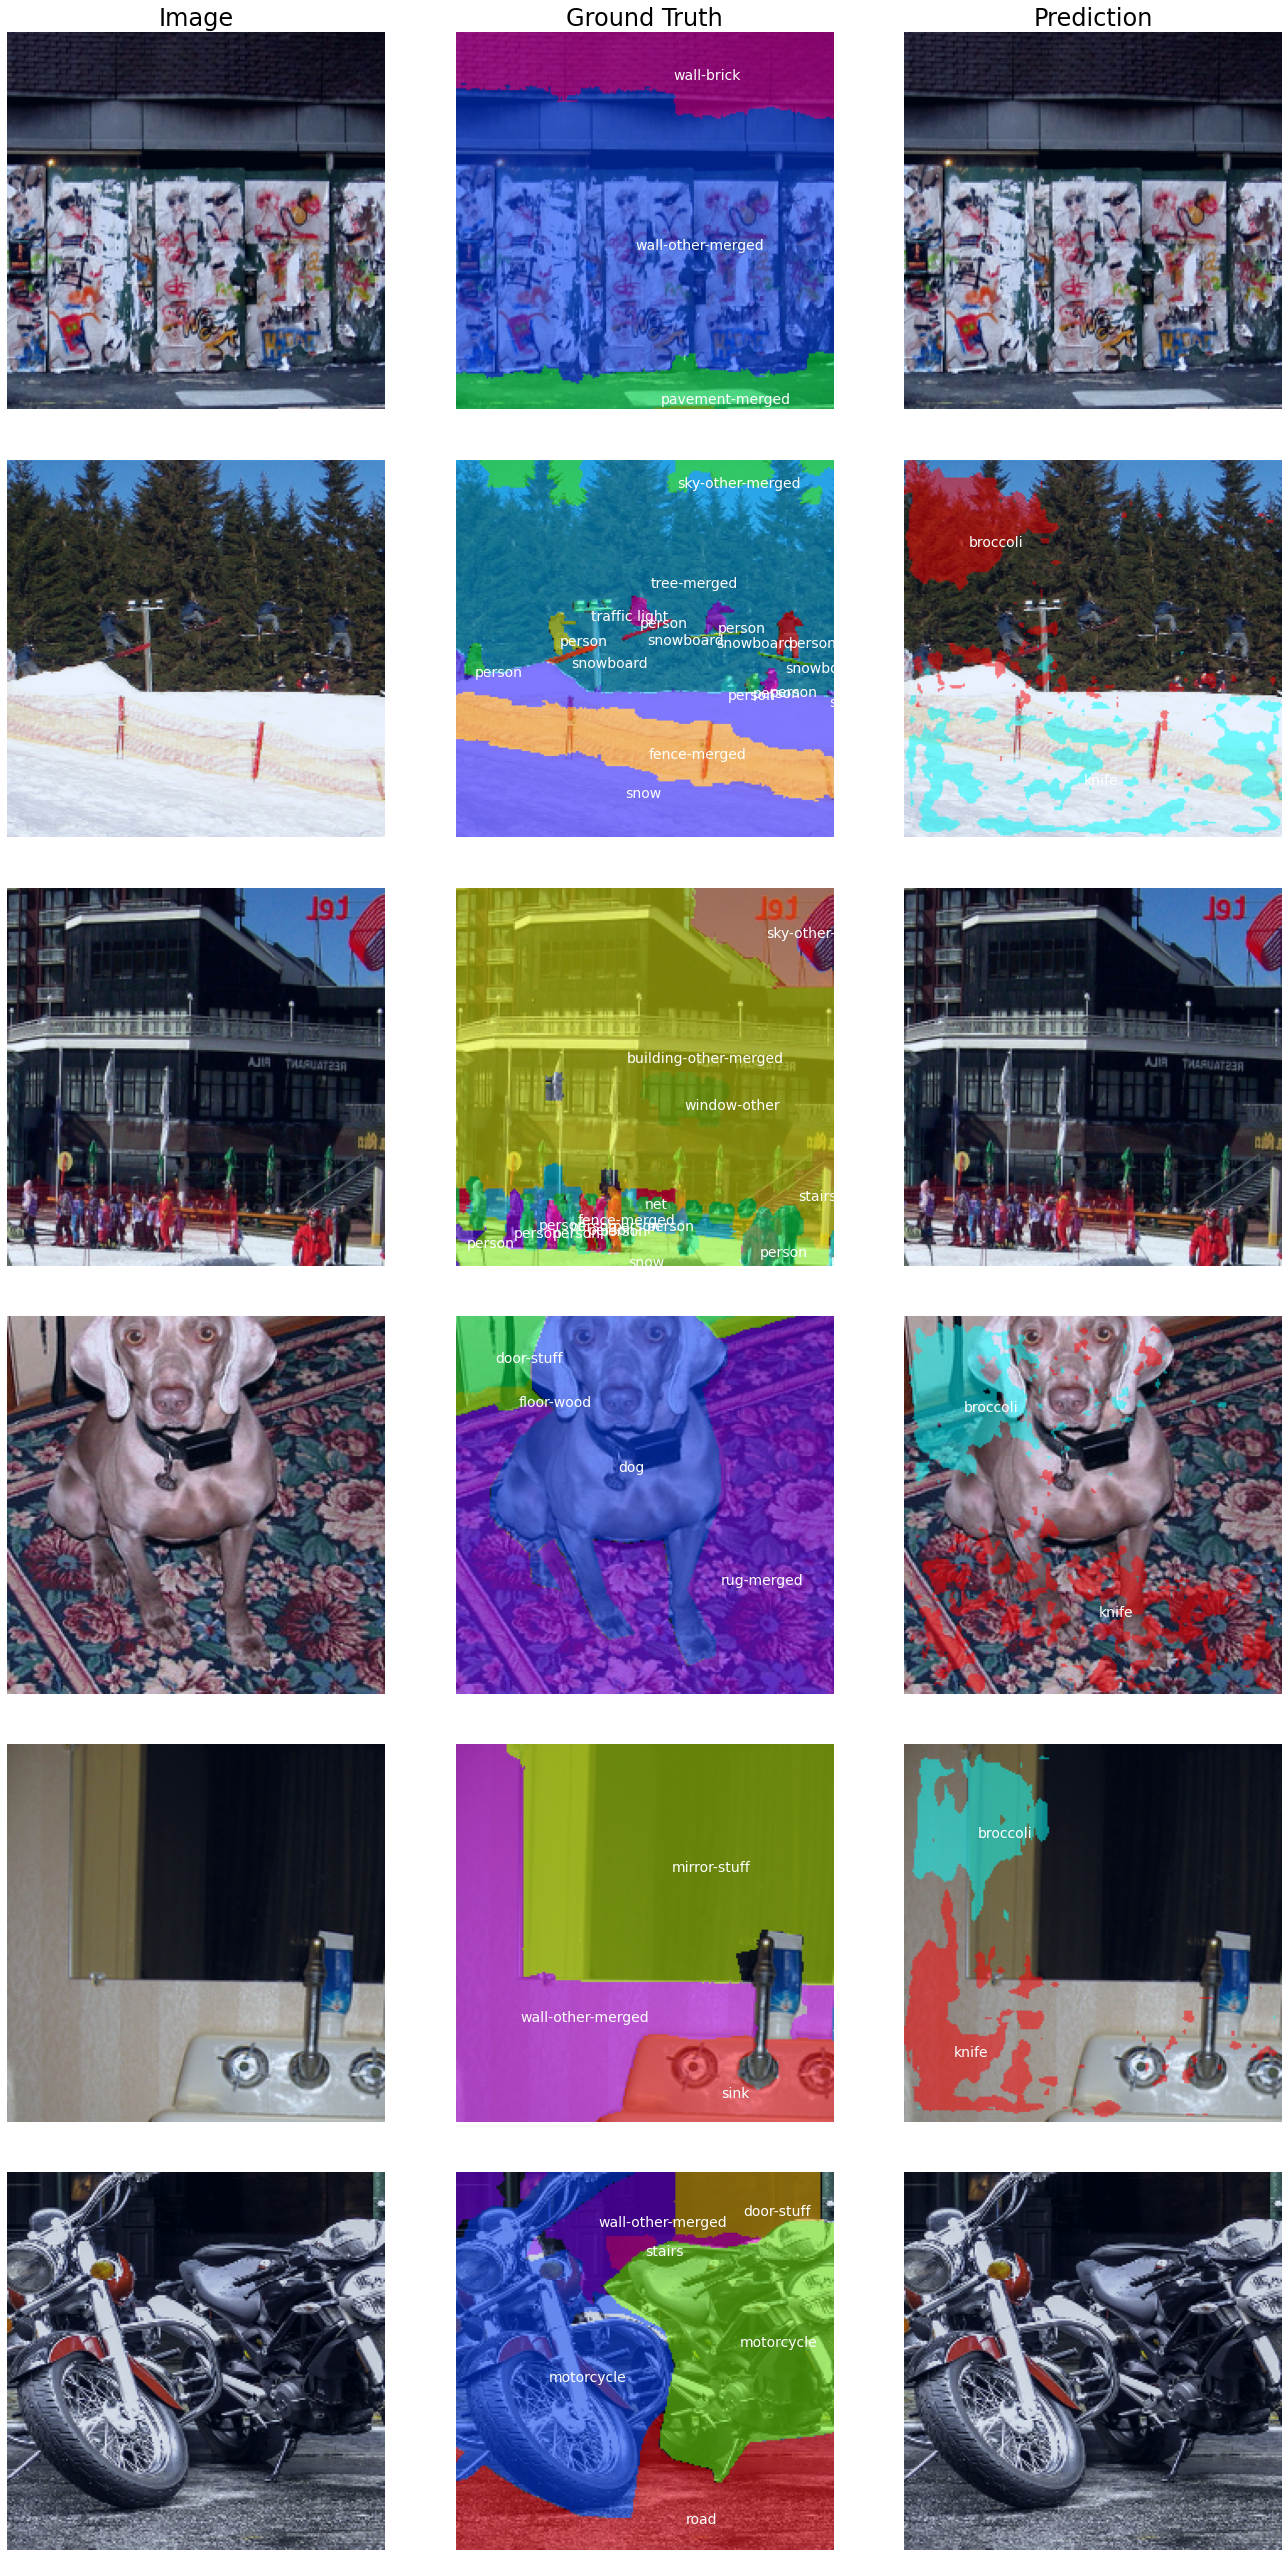

In [23]:
# ljh-图像显示打印
f, ax = plt.subplots(6, 3, figsize=(18, 18*bsz), squeeze=False)

for index in range(6):
    ax[index, 0].imshow(display_image[index])
    ax[index, 0].axis('off')
    display_instances(display_image[index], gt_instances[index], gt_class_names[index], ax=ax[index, 1])
    display_instances(display_image[index], pred_instances[index], pred_class_names[index], ax=ax[index, 2])

ax[0, 0].set_title('Image', fontsize=24)
ax[0, 1].set_title('Ground Truth', fontsize=24)
ax[0, 2].set_title('Prediction', fontsize=24)
plt.tight_layout()

In [31]:
#basic inference
with torch.no_grad():

    out = model(P)

    instance_probs = F.softmax(out[0], dim=1)
    instances = instance_probs.argmax(dim=1)
    instances = F.one_hot(instances, num_classes=N).permute(0, 3, 1, 2)
    
    #filter out pixels by mask id confidence
    #instances[instance_probs < 0.4] = 0
    
    class_confidence, classes = F.softmax(out[1], dim=-1).max(-1)

    semantic = F.softmax(out[2], dim=1).argmax(dim=1)

    #throughout padding instances in gt
    keep_gt_instances = torch.where(batch['labels'].tensors > 0)

    #filter out low confidence instances from predictions
    keep_pred_instances = torch.where(torch.logical_and(classes > 0, class_confidence > 0.7))

RuntimeError: CUDA out of memory. Tried to allocate 1.13 GiB (GPU 0; 4.00 GiB total capacity; 1.39 GiB already allocated; 698.84 MiB free; 2.04 GiB reserved in total by PyTorch)

In [23]:
gt_instances = []
gt_classes = []
gt_class_names = []

pred_instances = []
pred_classes = []
pred_class_names = []

for index in range(bsz):
    keep_gt = keep_gt_instances[1][keep_gt_instances[0] == index]
    keep_pred = keep_pred_instances[1][keep_pred_instances[0] == index]
    
    gt_instances.append(batch['masks'].tensors.detach()[index, keep_gt].cpu().numpy())
    gt_classes.append(batch['labels'].tensors.detach()[index, keep_gt].cpu().numpy())
    gt_class_names.append([category_dict[l] for l in gt_classes[-1]])

    pred_instances.append(instances.detach()[index, keep_pred].cpu().numpy())
    pred_classes.append(classes.detach()[index, keep_pred].cpu().numpy())
    pred_class_names.append([category_dict[l] for l in pred_classes[-1]])

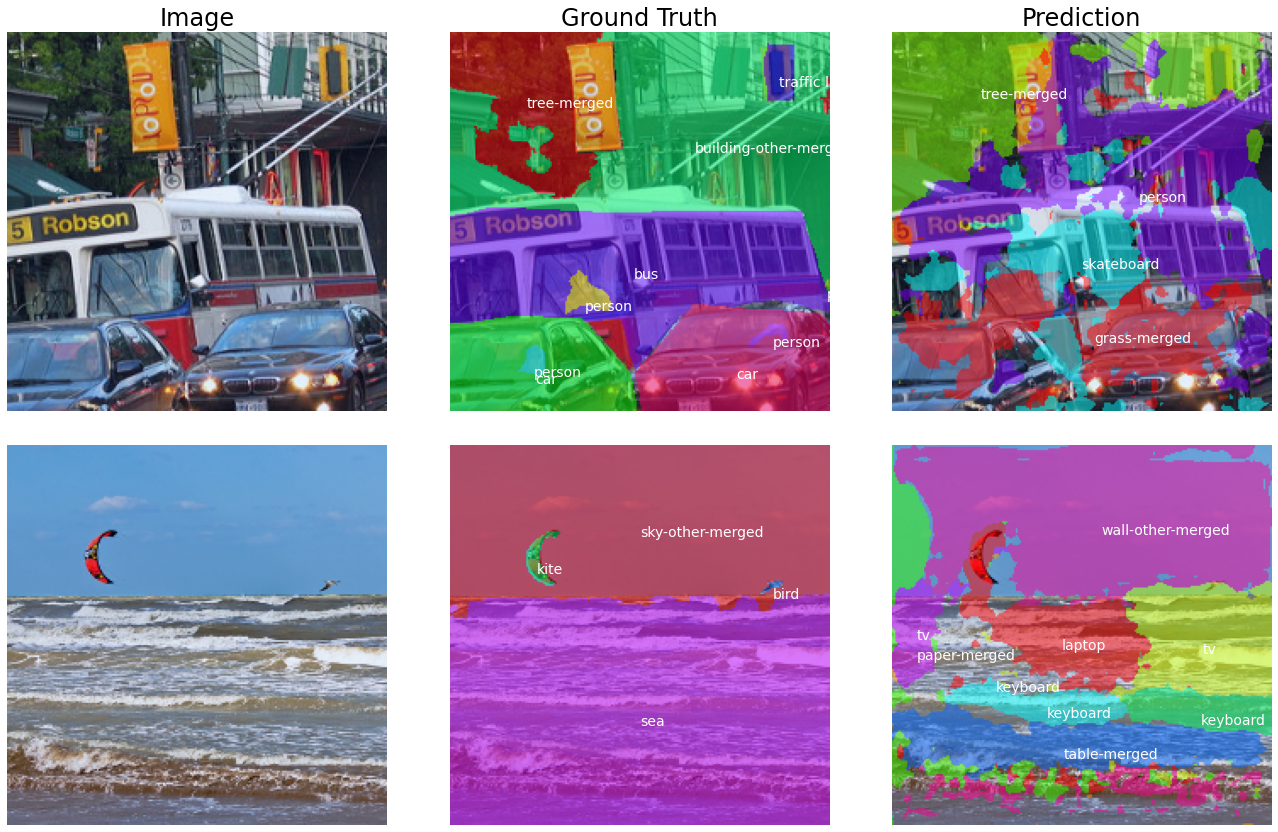

In [24]:
f, ax = plt.subplots(bsz, 3, figsize=(18, 6*bsz), squeeze=False)

for index in range(bsz):
    display_image = roll_image(batch['image'].tensors.detach().cpu().numpy()[index])
    ax[index, 0].imshow(display_image)
    ax[index, 0].axis('off')
    display_instances(display_image, gt_instances[index], gt_class_names[index], ax=ax[index, 1])
    display_instances(display_image, pred_instances[index], pred_class_names[index], ax=ax[index, 2])

ax[0, 0].set_title('Image', fontsize=24)
ax[0, 1].set_title('Ground Truth', fontsize=24)
ax[0, 2].set_title('Prediction', fontsize=24)
plt.tight_layout()